In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor
from VocalFeatureExtractor import VocalFeatureExtractor

### Loading Data ###

#### Loading and processing all trials from all days #####

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

#### Creating dictionary structure for lookup #####

In [3]:
mouse_ids = ["MBI5335RR", "VBQ0261L"]
days = [f"d{i}" for i in range(1, 11)]

experiment_data = {}

for ms_id in mouse_ids:
    experiment_data[ms_id] = {}
    for d in days:
        # Load data
        data = DL.get_data_for_experiment(mouse_id = ms_id,
                                          day = d)
        if data is None:
            print("Data not found for mouse", ms_id, "on day", d)
            continue

        experiment_data[ms_id][d] = data

#### Code for offsetting times in d1, MBI5335RR (run only once!!!) ####

In [4]:
# # add 5.5s to all the DLC_summary_columns for mouse MBI5335RR d1
# mouse_id = "MBI5335RR"
# day = "d1"

# # get the data for the session
# data_d1 = DL.get_data_for_experiment(mouse_id = mouse_id, day = day)
# df_summary = data_d1["Behavior"]["df_summary"]

# #print(df_summary)

# # for each column in DLC_summary_columns, add 5.5s

# for key, col in DL.config["DLC_summary_columns"].items():
#     if key not in ["trial_success", "trial_num", "pup_displacement_position]:
#         df_summary[col] = df_summary[col] + 5.5

# print(df_summary.head())

# # export and replace as csv using the same file_name
# filename = "MBI5335RR_240304_d1_BehavSummary.csv"
# path_dir = "./data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_240304_d1_Behavior/"

# df_summary.to_csv(os.path.join(path_dir, filename), index=False)

### First look at new pup data and noise ###

In [5]:
# select mouse_id and day
mouse_id = "MBI5335RR"
day = "d1"

# get the data for the session
data_d1 = DL.get_data_for_experiment(mouse_id, day = day)
df_summary = data_d1["Behavior"]["df_summary"]
df_dlc = data_d1["Behavior"]["df_dlc"]

In [6]:
xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]
nest_bounds = BF.config["nest_bounds"]

In [7]:
from colour import Color
red = Color("orange")
colors = list(red.range_to(Color("purple"),3))


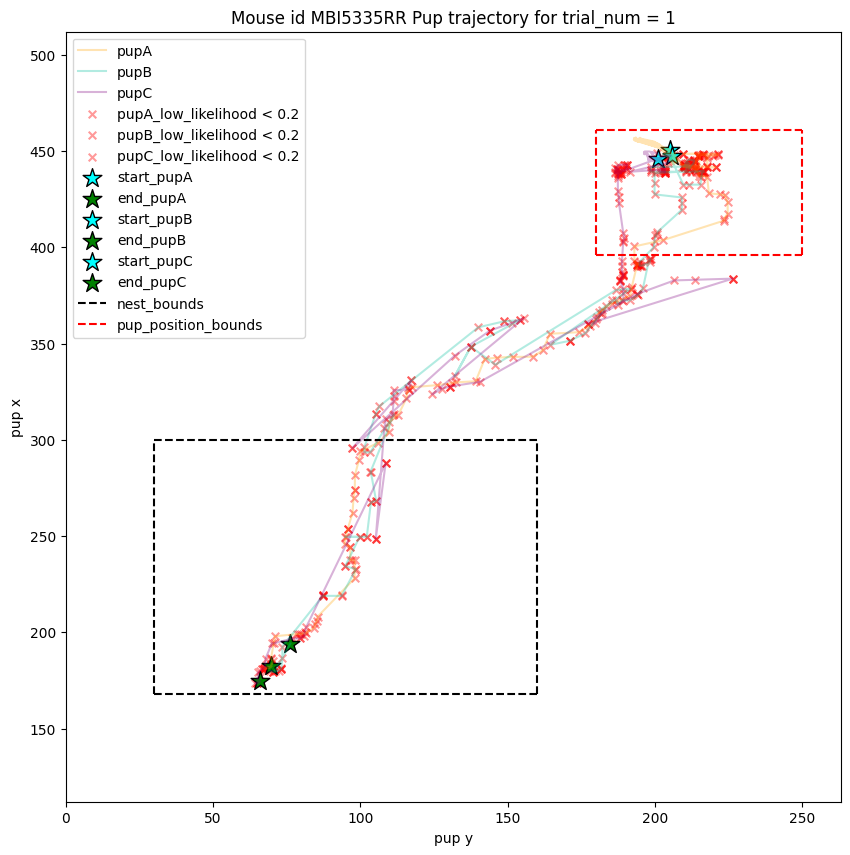

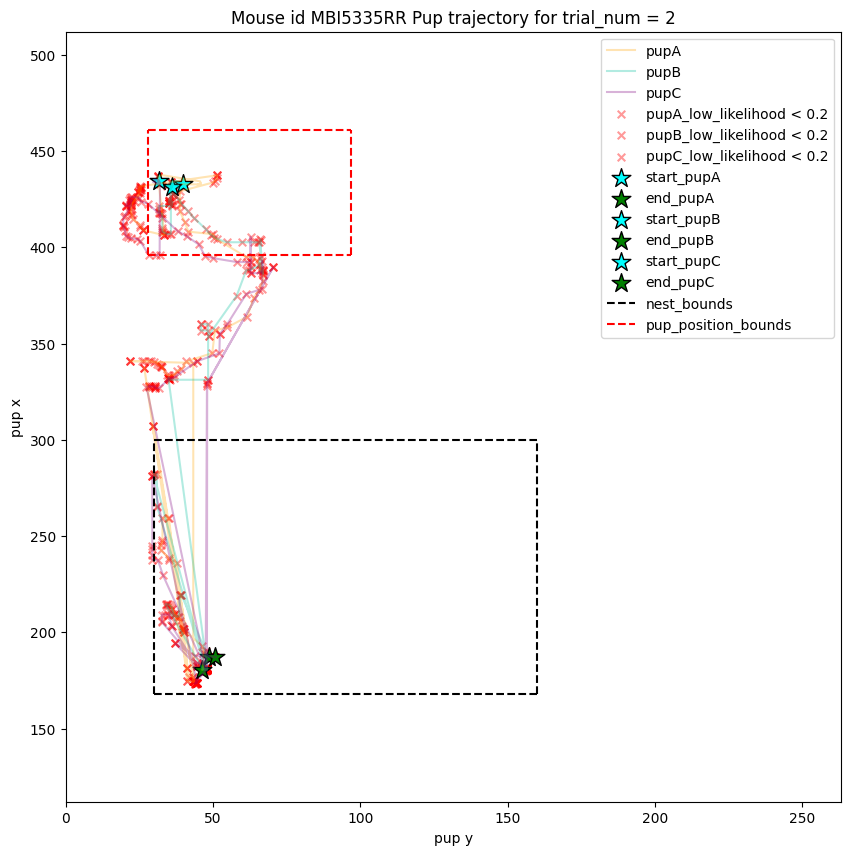

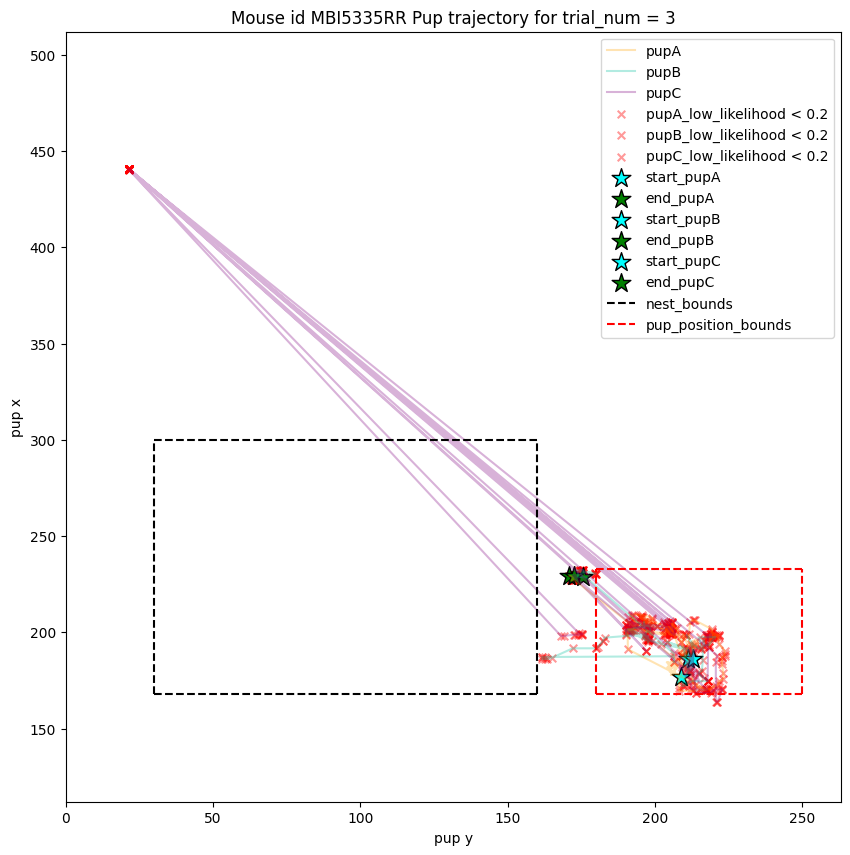

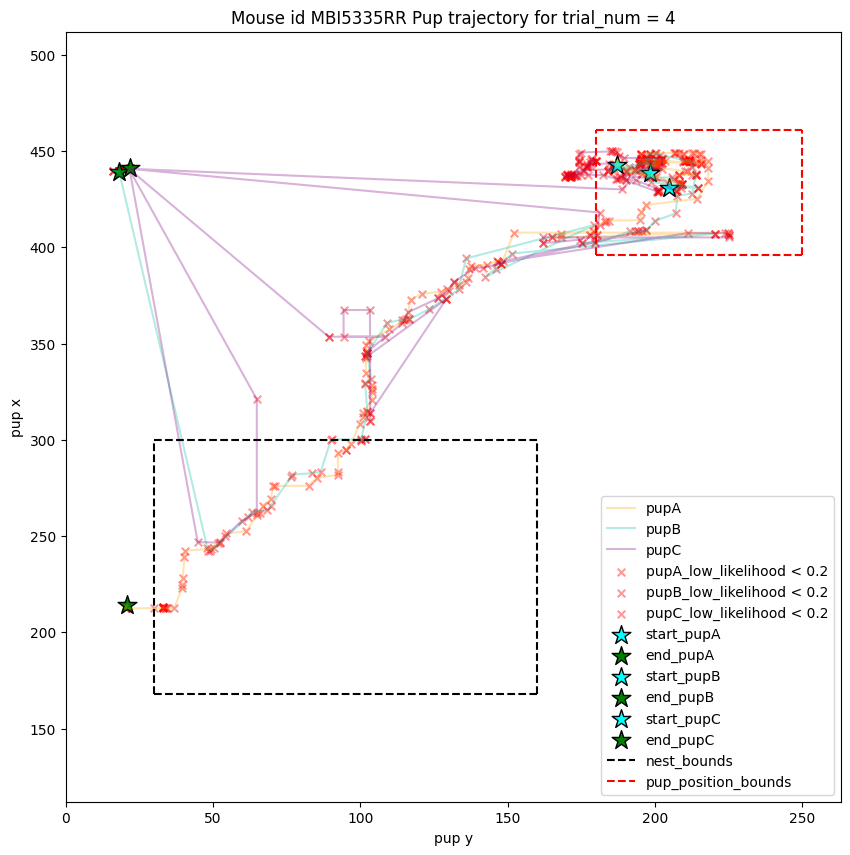

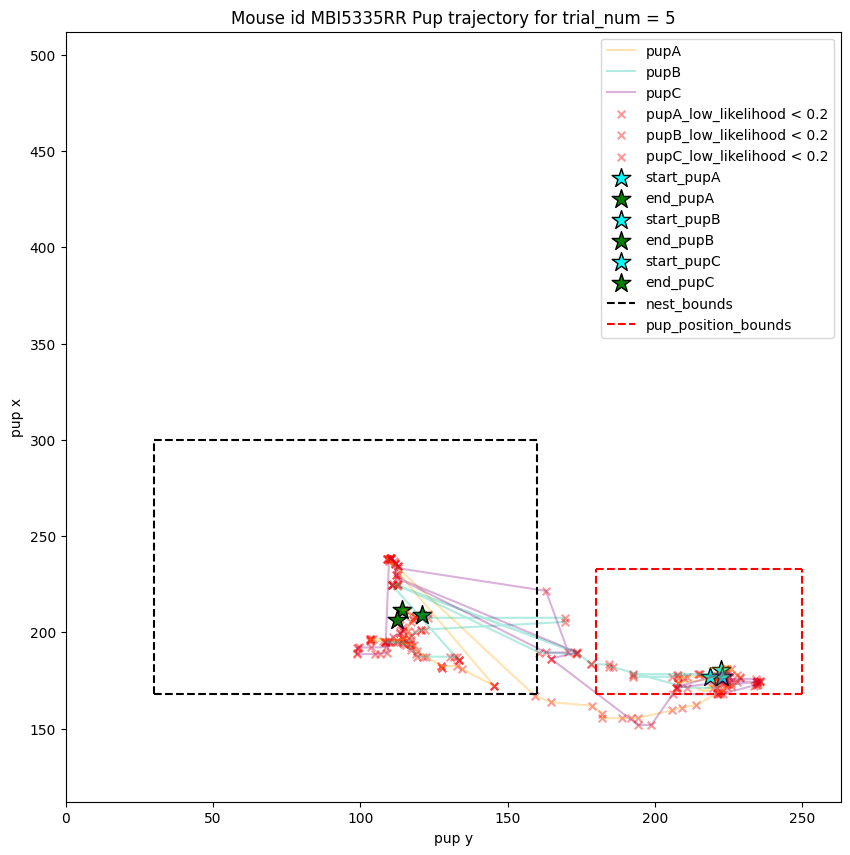

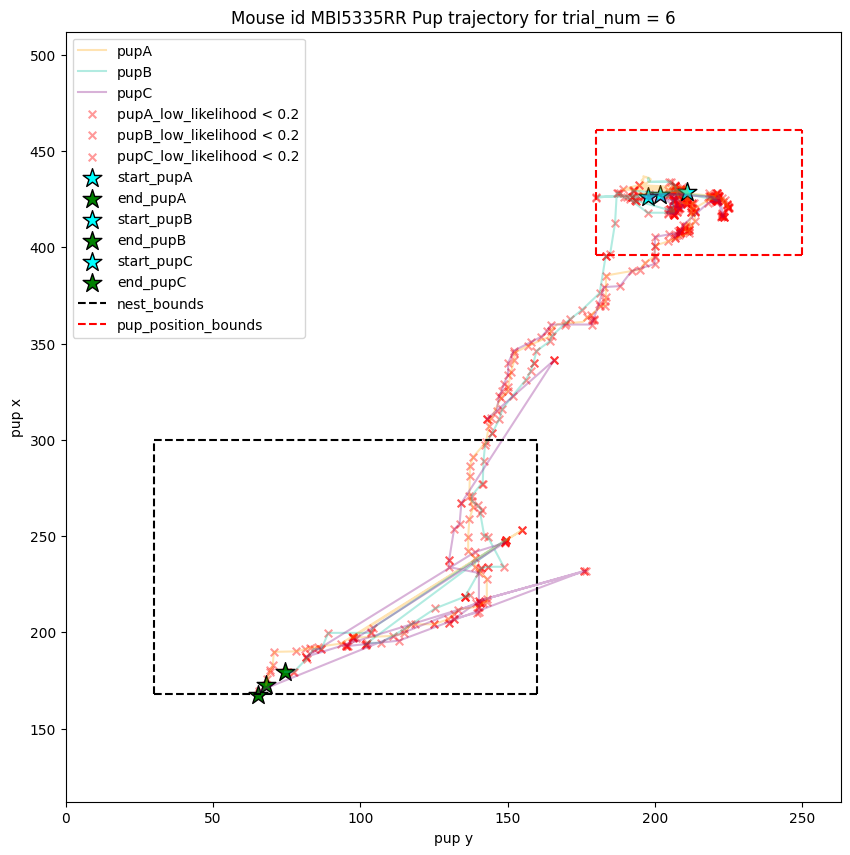

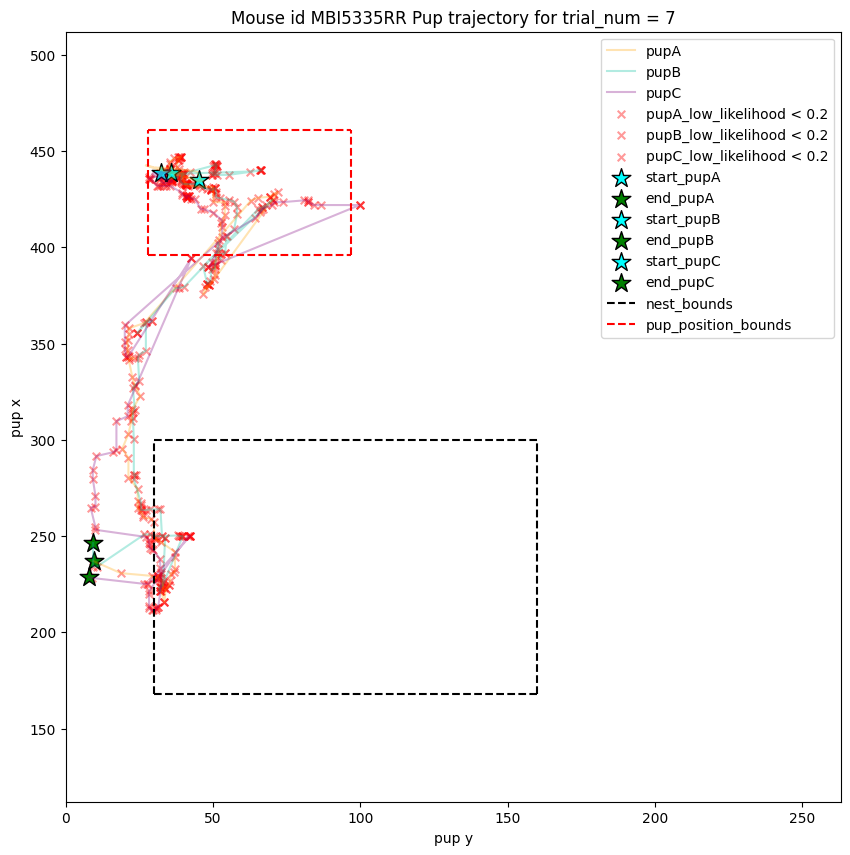

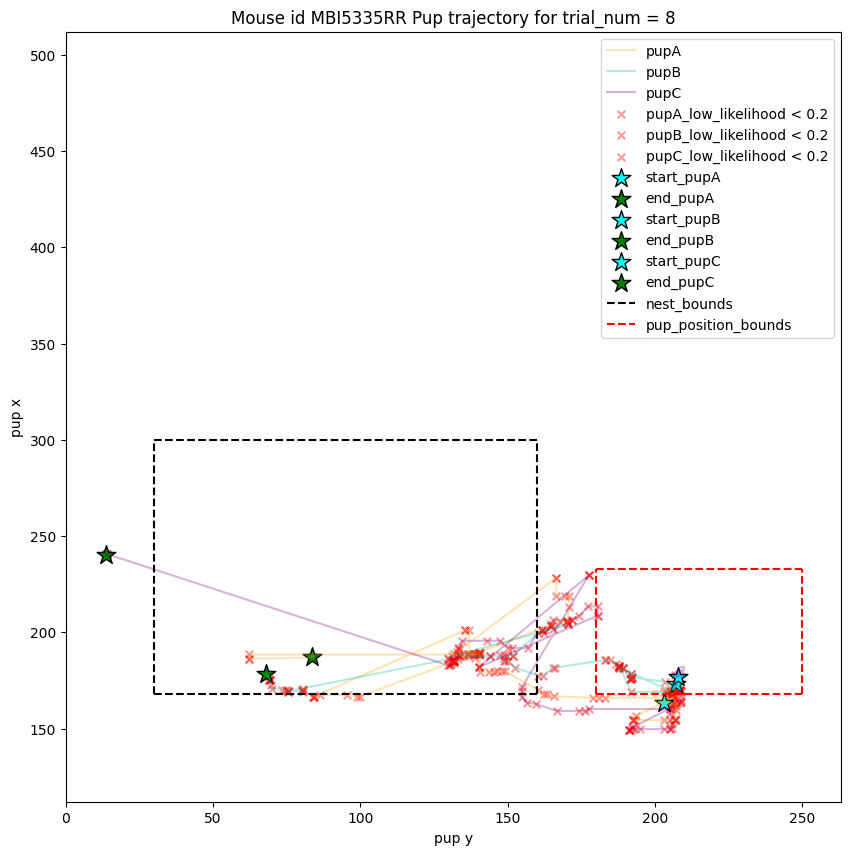

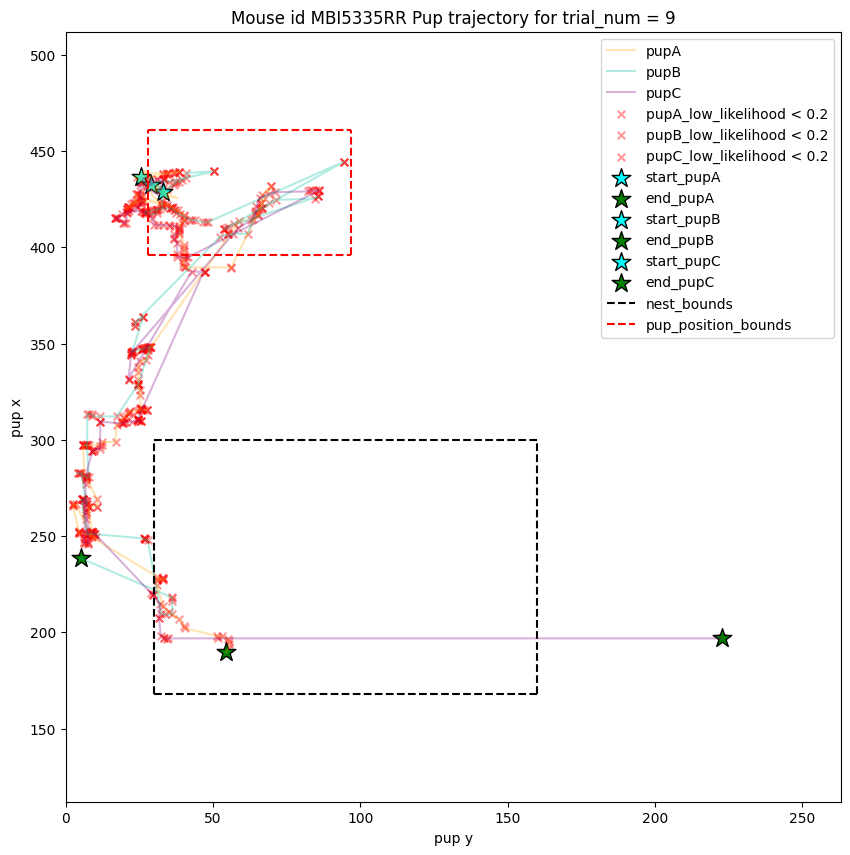

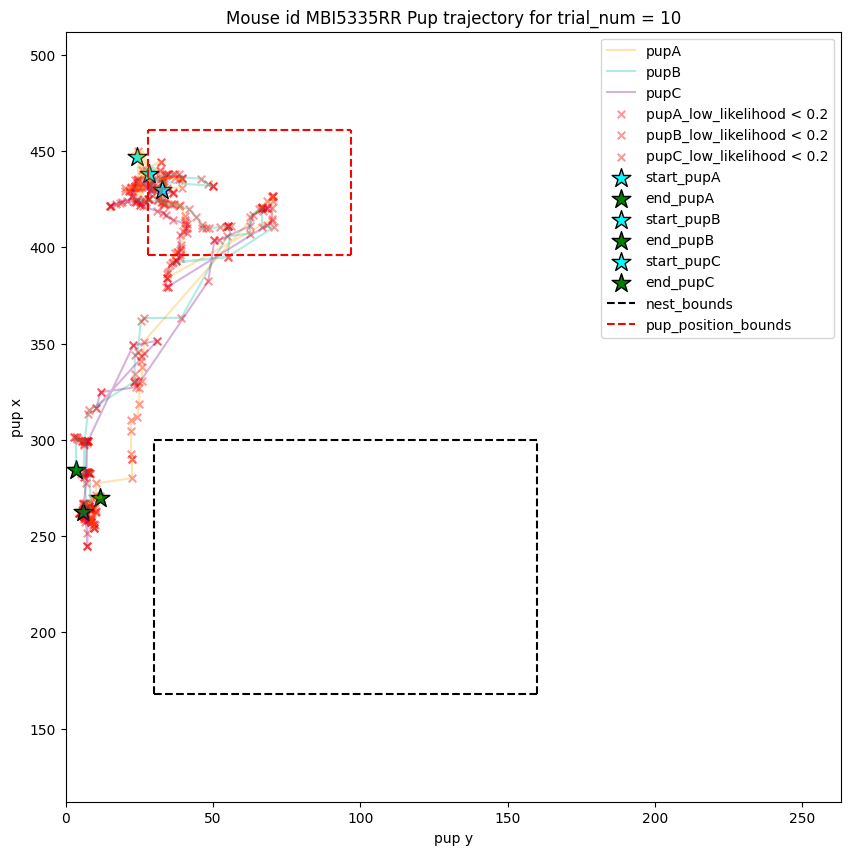

In [16]:
# visualize pup trajectory
#trial_num = 9
threshold_likelihood_pup = 0.2
#trial_dlc, mask_dlc = BF.extract_trial_from_DLC(df_dlc, df_summary, trial_num = trial_num)

for trial_num in range(1, 11):
    trial_dlc, mask_dlc = BF.extract_trial_from_DLC(df_dlc, df_summary, trial_num = trial_num)

    pup_position_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)

    # plot the trajectory of pupA, pupB, pupC on the same plot
    fig, ax = plt.subplots(figsize = (10,10))

    for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        trial_dlc.plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
                    kind = "line",
                    ax = ax,
                    alpha = 0.3,
                    color = colors[i].rgb, label = pup)
    # connect lines between the points

    # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
    #     trial_dlc.plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
    #                 kind = "line",
    #                 ax = ax,
    #                 alpha = 0.3,
    #                 color = colors[i].rgb, label = pup)
          
    for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        # add a red cross if likelihood is below threshold_likelihood_pup
        mask = trial_dlc[BF.DLC_cols[pup]["likelihood"]] < threshold_likelihood_pup
        trial_dlc.loc[mask].plot(x = BF.DLC_cols[pup]["y"],
                                y = BF.DLC_cols[pup]["x"],
                                marker = "x",
                                kind = "scatter",
                                ax = ax,
                                alpha = 0.4,
                                s = 30,
                                color = "red",
                                label = f"{pup}_low_likelihood < {threshold_likelihood_pup}")

    for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        # place start and end dot of size 200, with black outline
        trial_dlc.iloc[0:1].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
                            kind = "scatter",
                            marker = "*",
                            alpha = 1.,
                            s = 200,
                            edgecolors='black',
                            ax = ax,
                            color = "cyan", label = "start_" + pup)

        trial_dlc.iloc[-1:].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
                                kind = "scatter",
                                marker = "*",
                                alpha = 1.,
                                s = 200,
                                edgecolors='black',
                                ax = ax,
                                color = "green", label = "end_" + pup)
        

      
    # set x and y labels
    ax.set_xlabel("pup y")
    ax.set_ylabel("pup x")
        
    # set x and y limits
    ax.set_xlim([ymin, ymax])
    ax.set_ylim([xmin, xmax])
        
    # plot the arena
    ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
    ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
    ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
    ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest_bounds")

    # plot the pup position bounds
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmin"]], 'r--')
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmax"], pup_position_bounds["xmax"]], 'r--')
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymin"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--')
    ax.plot([pup_position_bounds["ymax"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--', label = "pup_position_bounds")



    ax.legend()
    ax.set_title(f"Mouse id {mouse_id} Pup trajectory for trial_num = {trial_num}")

### Generating Plots ###

#### Analysing latency from first call to retrieval ####

#### Trial start duration compared to latency duration #### 

#### Proximity of pup in relation to retrieval duration ####

#### Number of pup calls compared to retrieval ####